In [1]:
%reload_ext autoreload
%autoreload 2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import math

import pytorch_lightning as pl
import torch
from munch import Munch
from torch.utils.data import DataLoader, random_split

from qsr_learning.data import DRLDataset
from qsr_learning.models import DRLNet

In [3]:
config = Munch()

## Load checkpoint

In [4]:
mac_language_encoder_kwargs = {
    'encoder_type': 'lstm',
    'decoder_type': 'linear',
    'null_token': None,
    'encoder_vocab_size': None,
    'wordvec_dim': 300,
    'hidden_dim': 128,
    'rnn_num_layers': 1,
    'rnn_dropout': 0,
    'parameter_efficient': True,
    'output_batchnorm': False,
    'bidirectional': True,
    'gamma_option': 'linear', # not used
    'gamma_baseline': 1, # not used
    'use_attention': False, # not used
    'taking_context': True,
    'variational_embedding_dropout': 0.,
    'embedding_uniform_boundary': 1.0,
    'module_num_layers': 1,
    'num_modules': None, # from the mac model kwargs
}

film_language_encoder_kwargs = {
    'encoder_type': 'gru',
    'decoder_type': 'linear',
    'null_token': None,
    'encoder_vocab_size': None,
    'wordvec_dim': 200,
    'hidden_dim': 1024,
    'rnn_num_layers': 1,
    'rnn_dropout': 0,
    'parameter_efficient': True,
    'output_batchnorm': False,
    'bidirectional': False,
    'gamma_option': 'linear', # not used
    'gamma_baseline': 1, # not used
    'use_attention': False, # not used
    "num_modules": None,
}

mac_kwargs = {
    'vocab': None,
    'feature_dim': None, # raw images: [3,128,128]; resnet18 features: [256, 14, 14]
    'stem_num_layers': 6,
    'stem_batchnorm': True,
    'stem_kernel_size': [3],
    'stem_subsample_layers': [1,3], # add MaxPool2d(kernel_size=2, stride=2)
    'stem_stride': [1],
    'stem_padding': None,
    'stem_dim': 64,
    'num_modules': None,
    'module_dim': 128,
    'question_embedding_dropout': 0.,
    'stem_dropout': 0.,
    'memory_dropout': 0.,
    'read_dropout': 0.,
    'nonlinearity': 'ELU',
    'use_prior_control_in_control_unit': 0 == 1,
    'use_self_attention': 0,
    'use_memory_gate': 0,
    'question2output': 1,
    'classifier_batchnorm': 0 == 1,
    'classifier_fc_layers': [1024],
    'classifier_dropout': 0.,
    'use_coords': 1, # 1, 0
    'write_unit': 'original',
    'read_connect': 'last',
    'noisy_controls': bool(0),
    'debug_every': float('inf'),
    'print_verbose_every': float('inf'),
    'hard_code_control' : False
    }
    
film_kwargs = {
    'vocab': None,
    'feature_dim': None, # raw images: [3,128,128]; resnet18 features: [256, 14, 14]
    'stem_num_layers': 6,
    'stem_batchnorm': True,
    'stem_kernel_size': [3],
    'stem_subsample_layers': [1,3], # add MaxPool2d(kernel_size=2, stride=2)
    'stem_stride': [1],
    'stem_padding': None,
    'stem_dim': 64,
    'num_modules': None,
    'module_num_layers': 1,
    'module_dim': 64, #was 128 in original FiLM`
    'module_residual': True,
    'module_intermediate_batchnorm': False,
    'module_batchnorm': True,
    'module_batchnorm_affine': False,
    'module_dropout': 0e-2,
    'module_input_proj': 1,
    'module_kernel_size': 3,
    'classifier_proj_dim': 512,
    'classifier_downsample': 'maxpool2',
    'classifier_fc_layers': [1024],
    'classifier_batchnorm': True,
    'classifier_dropout': 0,
    'condition_method': 'bn-film',
    'condition_pattern': None, # [1,1,1,1], # length should be equal to "num_modules"
    'use_gamma': True,
    'use_beta': True,
    'use_coords': 1, # 1, 0
    'debug_every': float('inf'),
    'print_verbose_every': float('inf'),
}

In [5]:
import torch
def load_checkpoint(checkpoint):
    if os.path.isfile(checkpoint):
        print("=> loading checkpoint '{}'".format(checkpoint))
        cp = torch.load(checkpoint)
        return cp
    else:
        print("=> no checkpoint found at '{}'".format(checkpoint))
        raise Exception("No checkpoint found!")

In [156]:
#### 2 entities, intrinsic
# root_datadir = '/data/mli/qsr-learning/qsr-learning/data/intrinsic/torch_random_seed_1/num_entity_2/excluded_entity_18_excluded_relation_all4/image_size_128_emoji_size_24/'
# checkpoint_dirname = '2021-03-28 11:15:14.474585+02:00_film_num_modules_4' 
# checkpoint_dirname = '2021-03-28 23:12:55.798907+02:00_mac_num_modules_2'

#### 5 entities, intrinsic
root_datadir = '/data/mli/qsr-learning/qsr-learning/data/intrinsic/torch_random_seed_1/num_entity_5/excluded_entity_18_excluded_relation_all4/image_size_128_emoji_size_24/'
checkpoint_dirname = '2021-03-28 23:30:41.039363+02:00_mac_num_modules_2'
checkpoint_filename = 'final'
checkpoint_path = os.path.join(root_datadir, checkpoint_dirname, 'Checkpoints', 'ckpt_{}.pth.tar'.format(checkpoint_filename))
model_type = 'mac'
number_modules = 2
num_entity = 5
reference_type = 'intrinsic'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


cp = load_checkpoint(checkpoint_path)



=> loading checkpoint '/data/mli/qsr-learning/qsr-learning/data/intrinsic/torch_random_seed_1/num_entity_5/excluded_entity_18_excluded_relation_all4/image_size_128_emoji_size_24/2021-03-28 23:30:41.039363+02:00_mac_num_modules_2/Checkpoints/ckpt_final.pth.tar'


In [157]:
language_encoder = None
model = None
vocab = None
vocab = cp['vocab']
len(vocab['question_token_to_idx'])

38

In [158]:
from vr.models import MAC, FiLMedNet, FiLMGen
if model_type == "mac":
    mac_language_encoder_kwargs['null_token'] = vocab['question_token_to_idx']['NULL']
    mac_language_encoder_kwargs['encoder_vocab_size'] = len(vocab['question_token_to_idx'])
    mac_language_encoder_kwargs['num_modules'] = number_modules
    mac_kwargs['vocab'] = vocab
    mac_kwargs['feature_dim'] = [3,128,128]
    mac_kwargs['num_modules'] = number_modules
    language_encoder = FiLMGen(**mac_language_encoder_kwargs).to(device)
    model = MAC(**mac_kwargs).to(device)
elif model_type == "film":
    film_language_encoder_kwargs['null_token'] = vocab['question_token_to_idx']['NULL']
    film_language_encoder_kwargs['encoder_vocab_size'] = len(vocab['question_token_to_idx'])
    film_language_encoder_kwargs['num_modules'] = number_modules
    film_kwargs['vocab'] = vocab
    film_kwargs['feature_dim'] = [3,128,128]
    film_kwargs['num_modules'] = number_modules
    film_kwargs['condition_pattern'] = [1] * number_modules
    language_encoder = FiLMGen(**film_language_encoder_kwargs).to(device)
    model = FiLMedNet(**film_kwargs).to(device)

In [159]:
language_encoder.load_state_dict(cp["language_encoder_state"])
model.load_state_dict(cp["model_state"])
language_encoder.eval()
model.eval();

# Dataset

In [160]:
from qsr_learning.entity import emoji_names

In [161]:
entity_names = [
    "slightly smiling face",
    "nerd face",
    "smiling face with halo",
    "expressionless face",
    "flushed face",
    "face with tears of joy",
    "neutral face",
    "smiling face with heart-eyes",
    "face with medical mask",
    "loudly crying face",
    "hugging face",
    "smiling face with smiling eyes",
    "squinting face with tongue",
    "face with steam from nose",
    "dog face",
    "cat face",
    "face screaming in fear",
    "pouting face",
    "pig face",
    "rabbit face",
    "tiger face",
    "monkey face",
    "cow face",
    "tired face",
    "mouse face",
    "dragon face",
    "face with tongue",
    "sun with face",
    "worried face",
    "dizzy face",
    "face with open mouth",
    "fearful face",
]

excluded_entity_names = [
    "hugging face",
    "fearful face",
    "face with steam from nose",
    "face with tongue",
    "nerd face",
    "expressionless face",
    "dragon face",
    "flushed face",
    "cow face",
    "smiling face with heart-eyes",
    "sun with face",
    "pig face",
    "pouting face",
    "smiling face with halo",
    "slightly smiling face",
    "worried face",
    "neutral face",
    "loudly crying face",
]

relation_names_abs_intri = ["left_of", "right_of", "above", "below"]
excluded_relation_names_all4_abs_intri = ["left_of", "right_of", "above", "below"]


relation_names_rel = ["left_of", "right_of", "in_front_of", "behind"]
excluded_relation_names_all4_rel = ["left_of", "right_of", "in_front_of", "behind"]


In [52]:
if reference_type == "intrinsic" or args.reference_type == "absolute":
        relation_names = relation_names_abs_intri
        excluded_relation_names = excluded_relation_names_all4_abs_intri
        pass
elif reference_type == "relative":
    relation_names = relation_names_rel
    excluded_relation_names = excluded_relation_names_all4_rel
    pass
else:
    raise

In [162]:
config.dataset = Munch(
        vocab=list(vocab["question_token_to_idx"].keys()),
        entity_names=entity_names,
        relation_names=relation_names,
        num_entities=num_entity,
        frame_of_reference= "intrinsic", # "intrinsic" or "absolute"
        w_range=(24, 24), #(8, 8) (16, 16) (24, 24) (32, 32)
        h_range=(24, 24), #(8, 8)
        theta_range=(0, 2 * math.pi),
        add_bbox=False,
        add_front=False,
        transform=None,
        canvas_size=(128, 128), #(224, 224) (128, 128) (64, 64)
        num_samples=1000,
        root_seed=0,
    )

In [163]:

config.data_loader = Munch(
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )
test_dataset = DRLDataset(
            **{
                **config.dataset,
                **dict(
                    entity_names=excluded_entity_names,
                    excluded_entity_names=[],
                    relation_names=excluded_relation_names,
                    excluded_relation_names=[],
                    num_samples=100,
                    root_seed=10 ** 7,
                ),
            }
        )
test_loader = DataLoader(
        test_dataset, **{**config.data_loader, "shuffle": False}
    )
len(test_dataset)

100

In [154]:
## 2 entities
from ipywidgets import interact
from qsr_learning.binary_relation import above, below, left_of, right_of
from qsr_learning.data import DRLDataset

import math
from PIL import Image
from qsr_learning.entity import Entity

dataset = test_dataset

question = ["face with open mouth", "below", "hugging face"]
question_t = torch.tensor([dataset.word2idx[w] for w in question], dtype=torch.long)
# answer = 0
# answer_t = torch.tensor(answer, dtype=torch.float)

@interact(
    frame_of_reference=(0, 1),
    x1=(0, 105),
    y1=(0, 105),
    theta1=(0, 360),
    x2=(0, 105),
    y2=(0, 105),
    theta2=(0, 360),
)
def test_spatial_relations(
    frame_of_reference=0, x1=30, y1=30, theta1=0, x2=64, y2=64, theta2=150
):
    canvas = Image.new("RGBA", (128, 128), (0, 0, 0, 255))
    entity1 = Entity(
        name="face with open mouth",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x1, y1),
        theta=theta1 / 360 * 2 * math.pi,
        size=(24, 24),
    )
    entity1.draw(canvas, add_bbox=False, add_front=False)
    entity2 = Entity(
        name="hugging face",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x2, y2),
        theta=theta2 / 360 * 2 * math.pi,
        size=(24, 24),
    )
    entity2.draw(canvas, add_bbox=False, add_front=False)
    background = Image.new("RGBA", canvas.size, (0, 0, 0))
    image = Image.alpha_composite(background, canvas).convert("RGB")
    display(image)
    
    image_t = dataset.transform(image)
    questions_var = question_t.unsqueeze(0).to(device)
    questions_feat = language_encoder(questions_var)
    images_var = image_t.unsqueeze(0).to(device)
    if model_type == "mac":
        scores = model(images_var, questions_feat, isTest=True)
    elif model_type == "film":
        scores = model(images_var, questions_feat)
        
    if scores is not None:
        _, preds = scores.data.cpu().max(1)
        print("Question:", ' '.join(question))
        print("Prediction: ", bool(preds.item()))
        print("scores:", scores.data.softmax(dim=1)[0,1].item())
        

interactive(children=(IntSlider(value=0, description='frame_of_reference', max=1), IntSlider(value=30, descrip…

In [171]:
## 5 entities
from ipywidgets import interact
from qsr_learning.binary_relation import above, below, left_of, right_of
from qsr_learning.data import DRLDataset

import math
from PIL import Image
from qsr_learning.entity import Entity

dataset = test_dataset

question = ["face with tongue", "above", "nerd face"]
question_t = torch.tensor([dataset.word2idx[w] for w in question], dtype=torch.long)
# answer = 0
# answer_t = torch.tensor(answer, dtype=torch.float)

@interact(
    frame_of_reference=(0, 1),
    x1=(0, 105),
    y1=(0, 105),
    theta1=(0, 360),
    x2=(0, 105),
    y2=(0, 105),
    theta2=(0, 360),
    x3=(0, 105),
    y3=(0, 105),
    theta3=(0, 360),
    x4=(0, 105),
    y4=(0, 105),
    theta4=(0, 360),
    x5=(0, 105),
    y5=(0, 105),
    theta5=(0, 360),
)
def test_spatial_relations(
    frame_of_reference=0, x1=30, y1=30, theta1=0, x2=64, y2=64, theta2=150, \
    x3=10, y3=10, theta3=0, x4=70, y4=10, theta4=150, x5=10, y5=60, theta5=0
):
    canvas = Image.new("RGBA", (128, 128), (0, 0, 0, 255))
    entity1 = Entity(
        name="nerd face",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x1, y1),
        theta=theta1 / 360 * 2 * math.pi,
        size=(24, 24),
    )
    entity1.draw(canvas, add_bbox=False, add_front=False)
    entity2 = Entity(
        name="face with tongue",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x2, y2),
        theta=theta2 / 360 * 2 * math.pi,
        size=(24, 24),
    )
    entity2.draw(canvas, add_bbox=False, add_front=False)
    
    entity3 = Entity(
        name="slightly smiling face",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x3, y3),
        theta=theta3 / 360 * 2 * math.pi,
        size=(24, 24),
    )
    entity3.draw(canvas, add_bbox=False, add_front=False)
    
    entity4 = Entity(
        name="cow face",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x4, y4),
        theta=theta4 / 360 * 2 * math.pi,
        size=(24, 24),
    )
    entity4.draw(canvas, add_bbox=False, add_front=False)
    
    entity5 = Entity(
        name="pig face",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x5, y5),
        theta=theta5 / 360 * 2 * math.pi,
        size=(24, 24),
    )
    entity5.draw(canvas, add_bbox=False, add_front=False)
    
    background = Image.new("RGBA", canvas.size, (0, 0, 0))
    image = Image.alpha_composite(background, canvas).convert("RGB")
    display(image)
    
    image_t = dataset.transform(image)
    questions_var = question_t.unsqueeze(0).to(device)
    questions_feat = language_encoder(questions_var)
    images_var = image_t.unsqueeze(0).to(device)
    if model_type == "mac":
        scores = model(images_var, questions_feat, isTest=True)
    elif model_type == "film":
        scores = model(images_var, questions_feat)
        
    if scores is not None:
        _, preds = scores.data.cpu().max(1)
        print("Question:", ' '.join(question))
        print("Prediction: ", bool(preds.item()))
        print("scores:", scores.data.softmax(dim=1)[0,1].item())

interactive(children=(IntSlider(value=0, description='frame_of_reference', max=1), IntSlider(value=30, descrip…

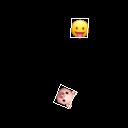

['face with tongue', 'below', 'pig face']
Ground truth:  False
Prediction:  True
scores: 0.9806837439537048
wroung!


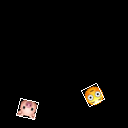

['pig face', 'below', 'flushed face']
Ground truth:  False
Prediction:  True
scores: 0.8370379209518433
wroung!


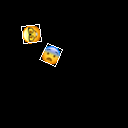

['nerd face', 'below', 'fearful face']
Ground truth:  False
Prediction:  True
scores: 0.9880157113075256
wroung!


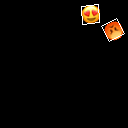

['pouting face', 'below', 'smiling face with heart-eyes']
Ground truth:  False
Prediction:  True
scores: 0.5272389054298401
wroung!


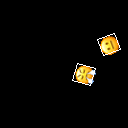

['neutral face', 'below', 'face with steam from nose']
Ground truth:  False
Prediction:  True
scores: 0.997940719127655
wroung!


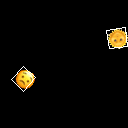

['worried face', 'above', 'sun with face']
Ground truth:  True
Prediction:  False
scores: 0.03959401696920395
wroung!


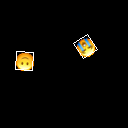

['slightly smiling face', 'below', 'loudly crying face']
Ground truth:  False
Prediction:  True
scores: 0.922211766242981
wroung!


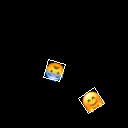

['hugging face', 'above', 'fearful face']
Ground truth:  False
Prediction:  True
scores: 0.8315033912658691
wroung!


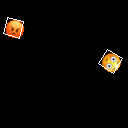

['flushed face', 'below', 'pouting face']
Ground truth:  False
Prediction:  True
scores: 0.925116240978241
wroung!


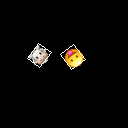

['face with tongue', 'right_of', 'cow face']
Ground truth:  False
Prediction:  True
scores: 0.9991514682769775
wroung!


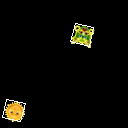

['dragon face', 'left_of', 'sun with face']
Ground truth:  True
Prediction:  False
scores: 0.23071053624153137
wroung!


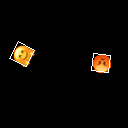

['hugging face', 'below', 'pouting face']
Ground truth:  False
Prediction:  True
scores: 0.9928779006004333
wroung!
cnt:12


In [139]:
from PIL import Image
cnt = 0
dataset = test_dataset
for idx in range(len(dataset)):
    image_t, question_t, answer_t = dataset[idx]
    questions_var = question_t.unsqueeze(0).to(device)
    questions_feat = language_encoder(questions_var)
    images_var = image_t.unsqueeze(0).to(device)
    answers_var = answer_t.unsqueeze(0).type(torch.LongTensor).to(device)
    if model_type == "mac":
        scores = model(images_var, questions_feat, isTest=True)
    elif model_type == "film":
        scores = model(images_var, questions_feat)

    if scores is not None:
        _, preds = scores.data.cpu().max(1)
        if preds == answer_t:
            pass
            # print("correct!")
        else:
            cnt += 1
            image = Image.fromarray(
                (255 * (dataset.std.view(-1, 1, 1) * image_t + dataset.mean.view(-1, 1, 1)))
                .permute(1, 2, 0)
                .numpy()
                .astype("uint8")
            )
            question = [dataset.idx2word[idx] for idx in question_t.tolist()]
            display(image)
            print(question)
            print("Ground truth: ", bool(answer_t))
            print("Prediction: ", bool(preds.item()))
            print("scores:", scores.data.softmax(dim=1)[0,1].item())
            print("wroung!")
print("cnt:{}".format(cnt))
    

In [55]:
from ipywidgets import interact
from PIL import Image
dataset = test_dataset
@interact(idx=(0, len(dataset) - 1))
def display_sample(idx=0):

    image_t, question_t, answer_t = dataset[idx]
    image = Image.fromarray(
        (255 * (dataset.std.view(-1, 1, 1) * image_t + dataset.mean.view(-1, 1, 1)))
        .permute(1, 2, 0)
        .numpy()
        .astype("uint8")
    )

    question = [dataset.idx2word[idx] for idx in question_t.tolist()]
    answer = bool(answer_t)
    display(image)
    print(question)
    print("Ground truth: ", answer)
    
    #(images, questions, answers) = batch # images.shape: [32, 3, 224, 224]
    questions_var = question_t.unsqueeze(0).to(device)
    questions_feat = language_encoder(questions_var)
    images_var = image_t.unsqueeze(0).to(device)
    answers_var = answer_t.unsqueeze(0).type(torch.LongTensor).to(device)
    if model_type == "mac":
        scores = model(images_var, questions_feat, isTest=True)
    elif model_type == "film":
        scores = model(images_var, questions_feat)

    if scores is not None:
        _, preds = scores.data.cpu().max(1)
        print("Prediction: ", bool(preds.item()))
        if preds == answer_t:
            print("correct!")
        else:
            print("wroung!")

interactive(children=(IntSlider(value=0, description='idx', max=999), Output()), _dom_classes=('widget-interac…

# Data Loader

In [ ]:
config.data_loader = Munch(
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

In [ ]:
train_loader = DataLoader(train_dataset, **config.data_loader)
validation_loader = DataLoader(
    validation_dataset, **{**config.data_loader, "shuffle": False}
)

In [ ]:
config.model = Munch(
    vision_model="resnet18",
    image_size=(3, *config.dataset.canvas_size),
    num_embeddings=len(dataset.word2idx),
    embedding_dim=10,
    question_len=dataset[0][1].shape.numel(),
)

model = DRLNet(**config.model)
lightning_checkpoint_path = (
    "lightning_logs/version_29/checkpoints/epoch=99-step=19599.ckpt"
)
model.load_state_dict(torch.load(lightning_checkpoint_path)["state_dict"])
model.eval();

## Evaluate on manual datasets

In [ ]:
from pprint import pprint

from ipywidgets import interact
from PIL import Image

from qsr_learning.data import Question, draw_entities
from qsr_learning.entity import Entity
from qsr_learning.relation import above, below, left_of, right_of


@interact(
    frame_of_reference=(0, 1),
    x1=(0, 190),
    y1=(0, 190),
    theta1=(0, 360),
    x2=(0, 190),
    y2=(0, 190),
    theta2=(0, 360),
)
def test_spatial_relations(
    frame_of_reference=1, x1=64, y1=64, theta1=0, x2=128, y2=128, theta2=150
):
    canvas = Image.new("RGBA", (224, 224), (127, 127, 127, 127))
    entity1 = Entity(
        name="octopus",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x1, y1),
        theta=theta1 / 360 * 2 * math.pi,
        size=(32, 32),
    )
    entity2 = Entity(
        name="trophy",
        frame_of_reference={0: "absolute", 1: "intrinsic"}[frame_of_reference],
        p=(x2, y2),
        theta=theta2 / 360 * 2 * math.pi,
        size=(32, 32),
    )
    image = draw_entities([entity1, entity2], add_bbox=True)
    background = Image.new("RGBA", image.size, (0, 0, 0))
    image = Image.alpha_composite(background, image).convert("RGB")
    display(image)
    image_t = dataset.transform(image)
    questions = []
    answers = []
    for relation in [right_of]:
        questions.append(Question(entity1.name, relation.__name__, entity2.name))
        answers.append(relation(entity1, entity2))
    #     for relation in dataset.relations:
    #         questions.append(Question(entity2.name, relation.__name__, entity1.name))
    #         answers.append(relation(entity2, entity1))
    for question, answer in zip(questions, answers):
        question_t = torch.tensor([dataset.word2idx[word] for word in question])
        answer_t = torch.tensor(answer)
        with torch.no_grad():
            pred_t = model(image_t.unsqueeze(0), question_t.unsqueeze(0))
        score = pred_t.sigmoid().item()
        pred = bool(pred_t.sigmoid().round())
        print(
            f"\n{question.head:7} {question.relation:8} {question.tail:7}\n\nGround Truth: {answer}\nPrediction  : {pred}\nScore       : {score:3.2f}\nCorrect     : {answer==pred:1}"
        )

## Display incorrect predictions

TODO: Getteng samples predicted incorrectly does not work yet.

In [ ]:
from tqdm.auto import tqdm

device = torch.device("cuda")
idx_incorrect = []
model.to(device)
with tqdm(total=(len(validation_dataset) // config.data_loader.batch_size + 1)) as pbar:
    for (i, batch) in enumerate(validation_loader):
        batch_size = batch[0].shape[0]
        image = batch[0].to(device)
        question = batch[1].to(device)
        answer = batch[2].to(device)
        idx = torch.arange(i * batch_size, (i + 1) * batch_size)
        idx_incorrect.extend(
            idx[answer != model(image, question).sigmoid().round()].tolist()
        )
        pbar.update(1)
model.to(torch.device("cpu"))

from ipywidgets import interact
from PIL import Image

subset = validation_dataset


@interact(idx=(0, len(idx_incorrect) - 1))
def display_sample(idx=0):
    idx = idx_incorrect[idx]
    image_t, question_t, answer_t = subset[idx]
    with torch.no_grad():
        pred_t = model(image_t.unsqueeze(0), question_t.unsqueeze(0))
    image = Image.fromarray(
        (255 * (dataset.std.view(-1, 1, 1) * image_t + dataset.mean.view(-1, 1, 1)))
        .permute(1, 2, 0)
        .numpy()
        .astype("uint8")
    )
    head, relation, tail = question_t.tolist()
    question = (
        dataset.idx2word[head],
        dataset.idx2word[relation],
        dataset.idx2word[tail],
    )
    answer = bool(answer_t)
    pred = bool(pred_t.round())
    display(image)
    print(question)
    print("Ground truth: ", answer)
    print("Prediction: ", pred)